In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd 'drive/My Drive/Siamese/Identification'

/content/drive/My Drive/Siamese/Identification


In [3]:
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../Data')
sys.path.insert(0, '../Encoder')

In [4]:
!pip install torchaudio

     |████████████████████████████████| 6.7MB 3.2MB/s 


In [5]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import Compose

from tqdm import tqdm

In [6]:
DATASET_PATH = '/content/drive/My Drive/DataSet'
MODEL_PATH = '/content/drive/My Drive/Siamese/net.nn'
EPOCH_NUM = 10

torch.backends.cudnn.deterministic = True

NUM_WORKERS = 4

In [7]:
from IdentificationDataset import IdentificationDataset
from IdentificationDataset import ReturnType

from Normalize import Normalize
from ToTensor import ToTensor

DATASET_PATH = '/content/drive/My Drive/DataSet'

transforms = Compose([
    Normalize(),
    ToTensor()
])

testset = IdentificationDataset(DATASET_PATH, 
                                40,
                                train=False, 
                                transform=transforms,
                                lenght=3,
                                return_type=ReturnType.STANDARD)
testsetloader = torch.utils.data.DataLoader(testset, 
                                            batch_size=1, 
                                            num_workers=NUM_WORKERS)

print("lenght test loader ", len(testsetloader))


sample lenght  3
lenght test loader  4874


In [8]:
from Conference import Conference

# Define default device, we should use the GPU (cuda) if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = Conference(DEVICE, time=False)

net.load_encoder(size=1)
net.to(DEVICE)

Encoder loaded


Conference(
  (encoder): TransFourier(
    (spectrogram): Spectrogram()
    (amp): AmplitudeToDB()
    (block1): Conv2DBlock(
      (conv1): Conv2d(1, 32, kernel_size=(1, 1), stride=(2, 1))
      (conv2): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 1), padding=(3, 3))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (maxpool): MaxPool2d(kernel_size=(4, 4), stride=(4, 4), padding=0, dilation=1, ceil_mode=False)
    )
    (block2): Conv2DBlock(
      (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(2, 1))
      (conv2): Conv2d(128, 192, kernel_size=(5, 5), stride=(2, 1), padding=(2, 2))
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (maxpool): MaxPool2d(kernel_size=(4, 2), stride=(4, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (block3): Conv2DBlock(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(2, 1))
      (conv2): Co

In [9]:
with torch.no_grad():
  # test
  net.eval()
  # Store the speakers
  speakers_list = testset.get_speakers_list(20)
  net.initspeakers(speakers_list)  
  net.initplaces(speakers_list)


In [10]:
import numpy as np

dict_error = {}
dict_nb = {}

with torch.no_grad():
  best_accuracy = 0
  mean_accuracies = []
  topk_accuracies = []
  min_accuracies = []

  for epoch_num in range(EPOCH_NUM):
    print("*** Epoch ", epoch_num, " ***")
    mean_accuracy = 0
    topk_accuracy = 0
    min_accuracy = 0
    nb_test = 0

    for speaker in speakers_list:
      id = speaker[0]
      dict_error[id] = 0
      dict_nb[id] = 0

    for iter_num, (gold_label, sample) in tqdm(enumerate(testsetloader)):
      mean_label, topk_label, min_label = net(sample, gold_label)
      nb_test += 1
      gold_label = gold_label.item()
      dict_nb[gold_label] += 1

      if gold_label == mean_label:
        mean_accuracy += 1
      if gold_label == topk_label:
        topk_accuracy += 1
      else:
        dict_error[gold_label] += 1
      if gold_label == min_label:
        min_accuracy += 1

    mean_accuracy /= nb_test
    topk_accuracy /= nb_test
    min_accuracy /= nb_test
    mean_accuracies.append(mean_accuracy)
    topk_accuracies.append(topk_accuracy)
    min_accuracies.append(min_accuracy)
    print("accuracy mean ", mean_accuracy, "topk", topk_accuracy, 
          " min ", min_accuracy)
    add = 0
    nb = 0
    for id in dict_error:
      add += dict_error[id]
      nb += dict_nb[id]
      dict_error[id] =  100 * dict_error[id]//dict_nb[id] 
    print("Error ", add/nb)
    print(dict_error)

  net.store_speakers(20, 3)

*** Epoch  0  ***


4874it [06:03, 13.43it/s]

accuracy mean  0.2950348789495281 topk 0.6887566680344686  min  0.7107098892080427
Error  0.3112433319655314
{270: 18, 272: 76, 273: 25, 274: 33, 275: 14, 276: 38, 277: 56, 278: 3, 271: 39, 279: 57, 280: 16, 281: 13, 282: 27, 283: 37, 285: 61, 284: 1, 286: 9, 287: 100, 288: 85, 289: 62, 290: 10, 291: 43, 292: 48, 293: 38, 294: 18, 295: 52, 296: 30, 297: 43, 298: 15, 299: 34, 300: 25, 301: 52, 302: 24, 303: 0, 304: 77, 305: 18, 306: 11, 307: 39, 308: 21, 309: 10}
*** Epoch  1  ***



4874it [02:16, 35.67it/s]

accuracy mean  0.5080016413623307 topk 0.7591300779647107  min  0.7560525235945835
Error  0.24086992203528929
{270: 10, 272: 60, 273: 39, 274: 27, 275: 17, 276: 18, 277: 47, 278: 5, 271: 32, 279: 36, 280: 11, 281: 13, 282: 27, 283: 34, 285: 39, 284: 3, 286: 10, 287: 91, 288: 62, 289: 6, 290: 12, 291: 14, 292: 18, 293: 29, 294: 18, 295: 40, 296: 22, 297: 30, 298: 11, 299: 34, 300: 31, 301: 45, 302: 24, 303: 2, 304: 43, 305: 22, 306: 13, 307: 25, 308: 15, 309: 6}
*** Epoch  2  ***



4874it [02:15, 35.86it/s]

accuracy mean  0.6073040623717686 topk 0.7700041034058268  min  0.766516208453016
Error  0.22999589659417316
{270: 6, 272: 48, 273: 42, 274: 24, 275: 13, 276: 20, 277: 32, 278: 6, 271: 23, 279: 36, 280: 14, 281: 10, 282: 17, 283: 35, 285: 29, 284: 6, 286: 15, 287: 52, 288: 41, 289: 4, 290: 15, 291: 14, 292: 18, 293: 35, 294: 21, 295: 27, 296: 23, 297: 27, 298: 9, 299: 36, 300: 33, 301: 37, 302: 27, 303: 2, 304: 33, 305: 23, 306: 16, 307: 27, 308: 15, 309: 6}
*** Epoch  3  ***



4874it [02:16, 35.62it/s]

accuracy mean  0.6616741895773492 topk 0.7675420599097251  min  0.7702092736971686
Error  0.23245794009027493
{270: 8, 272: 38, 273: 42, 274: 20, 275: 14, 276: 21, 277: 25, 278: 7, 271: 20, 279: 12, 280: 14, 281: 11, 282: 21, 283: 39, 285: 27, 284: 15, 286: 14, 287: 33, 288: 22, 289: 3, 290: 19, 291: 14, 292: 18, 293: 36, 294: 21, 295: 27, 296: 24, 297: 30, 298: 10, 299: 34, 300: 33, 301: 20, 302: 33, 303: 3, 304: 35, 305: 24, 306: 18, 307: 29, 308: 23, 309: 7}
*** Epoch  4  ***



4874it [02:16, 35.69it/s]

accuracy mean  0.6743947476405416 topk 0.7636438243742306  min  0.7640541649569143
Error  0.23635617562576938
{270: 8, 272: 22, 273: 47, 274: 20, 275: 16, 276: 25, 277: 25, 278: 9, 271: 19, 279: 9, 280: 13, 281: 14, 282: 21, 283: 39, 285: 30, 284: 18, 286: 11, 287: 27, 288: 18, 289: 4, 290: 19, 291: 14, 292: 16, 293: 37, 294: 21, 295: 25, 296: 24, 297: 30, 298: 10, 299: 28, 300: 36, 301: 16, 302: 34, 303: 4, 304: 35, 305: 26, 306: 17, 307: 29, 308: 29, 309: 7}
*** Epoch  5  ***



4874it [02:17, 35.35it/s]

accuracy mean  0.6723430447271235 topk 0.7583093967993435  min  0.7595404185473943
Error  0.24169060320065655
{270: 11, 272: 18, 273: 48, 274: 20, 275: 16, 276: 24, 277: 23, 278: 14, 271: 20, 279: 15, 280: 11, 281: 15, 282: 19, 283: 38, 285: 27, 284: 23, 286: 12, 287: 25, 288: 12, 289: 5, 290: 19, 291: 14, 292: 16, 293: 37, 294: 21, 295: 25, 296: 27, 297: 29, 298: 14, 299: 30, 300: 35, 301: 14, 302: 34, 303: 3, 304: 36, 305: 25, 306: 17, 307: 30, 308: 29, 309: 13}
*** Epoch  6  ***



4874it [02:17, 35.58it/s]

accuracy mean  0.6704965121050472 topk 0.7486663931062782  min  0.7517439474764054
Error  0.2513336068937218
{270: 11, 272: 20, 273: 50, 274: 18, 275: 16, 276: 23, 277: 26, 278: 16, 271: 26, 279: 19, 280: 11, 281: 16, 282: 22, 283: 37, 285: 30, 284: 24, 286: 12, 287: 20, 288: 12, 289: 5, 290: 19, 291: 14, 292: 18, 293: 39, 294: 21, 295: 26, 296: 29, 297: 31, 298: 19, 299: 26, 300: 35, 301: 16, 302: 38, 303: 2, 304: 37, 305: 26, 306: 17, 307: 31, 308: 29, 309: 16}
*** Epoch  7  ***



4874it [02:16, 35.60it/s]

accuracy mean  0.6787033237587198 topk 0.7418957734919983  min  0.7416906032006565
Error  0.25810422650800163
{270: 10, 272: 20, 273: 50, 274: 18, 275: 21, 276: 23, 277: 28, 278: 19, 271: 27, 279: 20, 280: 13, 281: 16, 282: 22, 283: 38, 285: 30, 284: 24, 286: 12, 287: 14, 288: 18, 289: 5, 290: 19, 291: 14, 292: 18, 293: 41, 294: 23, 295: 28, 296: 29, 297: 36, 298: 18, 299: 28, 300: 35, 301: 16, 302: 36, 303: 4, 304: 37, 305: 27, 306: 18, 307: 32, 308: 35, 309: 16}
*** Epoch  8  ***



4874it [02:16, 35.78it/s]

accuracy mean  0.679524004924087 topk 0.7427164546573656  min  0.7394337299958966
Error  0.25728354534263437
{270: 10, 272: 22, 273: 49, 274: 18, 275: 17, 276: 25, 277: 28, 278: 20, 271: 26, 279: 19, 280: 13, 281: 16, 282: 21, 283: 39, 285: 29, 284: 25, 286: 12, 287: 14, 288: 18, 289: 5, 290: 19, 291: 14, 292: 19, 293: 40, 294: 22, 295: 27, 296: 29, 297: 37, 298: 17, 299: 30, 300: 35, 301: 20, 302: 31, 303: 3, 304: 37, 305: 27, 306: 19, 307: 32, 308: 34, 309: 16}
*** Epoch  9  ***



4874it [02:16, 35.75it/s]


accuracy mean  0.6731637258924907 topk 0.7384078785391875  min  0.7402544111612639
Error  0.26159212146081245
{270: 10, 272: 20, 273: 52, 274: 18, 275: 22, 276: 24, 277: 29, 278: 21, 271: 26, 279: 25, 280: 14, 281: 15, 282: 23, 283: 41, 285: 27, 284: 24, 286: 12, 287: 8, 288: 20, 289: 5, 290: 20, 291: 14, 292: 18, 293: 41, 294: 23, 295: 31, 296: 34, 297: 36, 298: 18, 299: 30, 300: 35, 301: 20, 302: 31, 303: 2, 304: 38, 305: 27, 306: 19, 307: 31, 308: 35, 309: 13}


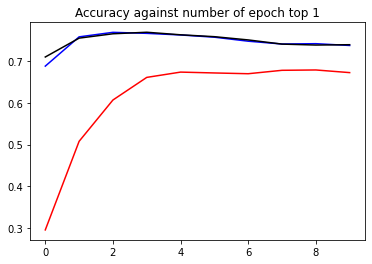

In [11]:
import matplotlib.pyplot as plt

plt.title("Accuracy against number of epoch top 1")
plt.plot([i for i in range(EPOCH_NUM)], mean_accuracies , label='test 1', color='red')
plt.plot([i for i in range(EPOCH_NUM)], topk_accuracies , label='test 1', color='blue')
plt.plot([i for i in range(EPOCH_NUM)], min_accuracies , label='test 1', color='black')


In [12]:
print("maximum of min", round(np.max(min_accuracies), 3))
print("maximum of topk", round(np.max(topk_accuracies), 3))
print("maximum of mean", round(np.max(mean_accuracies), 3))

maximum of min 0.77
maximum of topk 0.77
maximum of mean 0.68
